In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
from math import pi
from collections import deque


from scipy.sparse.csgraph import connected_components
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

data = np.load('/content/drive/My Drive/UW_ECON/y3/ML_big_data/project/data600.npy')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.shape

(10000, 600)

In [ ]:
print(np.min(data), np.max(data), np.mean(data), np.std(data))

-18758.737817758378 18102.882788611332 -164.9039152840584 5038.533274587233


In [ ]:
# Standardize
X = StandardScaler().fit_transform(data)

In [ ]:
print(np.min(X), np.max(X), np.mean(X), np.std(X))

-7.464779400790129 7.929985596366112 -1.14756204538935e-16 0.9999999999999997



Step 3: Computing covariance matrix...
Covariance matrix shape: (600, 600)
Computation time: 0.04 seconds
Computing eigenvalues and eigenvectors...
Eigendecomposition time: 0.08 seconds
Top 10 eigenvalues: [30.44233535 21.47914012 18.60219492 18.35710003 15.02057082 14.12012657
 13.70442882 11.88392887 11.49238777 11.03422626]
 Computing explained variance...
Components needed for 80% variance: 113
Components needed for 85% variance: 150
Components needed for 90% variance: 212
Components needed for 95% variance: 326
Components needed for 99% variance: 513

Choosing 326 components (95% variance)

Step 7: Projecting data to lower dimension...
Reduced data shape: (10000, 326)

Verifying orthogonality of PCs (should be identity matrix):
Max off-diagonal element: 0.000000
Creating visualizations...
Visualization saved to pca_analysis_600d.png


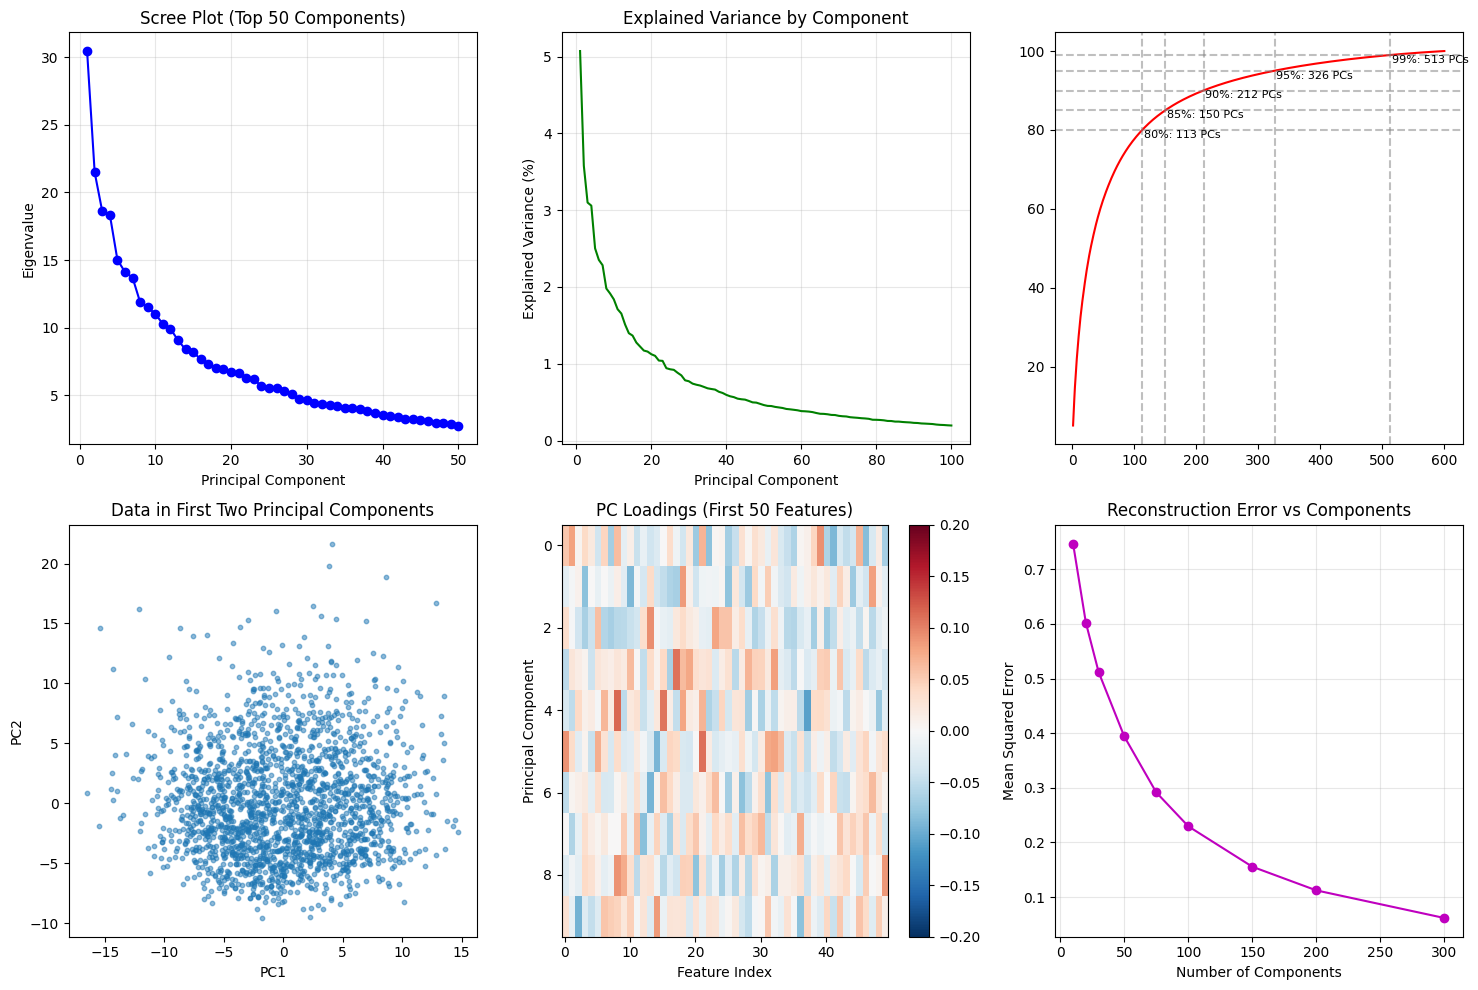

In [ ]:
# PCA, since it shows that I run out of RAM
import numpy as np
import matplotlib.pyplot as plt
import time

n, d = X.shape
# Compute covariance matrix (more efficient method for n >> d)
print("\nStep 3: Computing covariance matrix...")
start_time = time.time()

# For n >> d, compute X^T X instead of XX^T
# Covariance matrix: C = (1/(n-1)) * X^T * X
C = np.dot(X.T, X) / (n - 1)
print(f"Covariance matrix shape: {C.shape}")
print(f"Computation time: {time.time() - start_time:.2f} seconds")

# Eigendecomposition
print("Computing eigenvalues and eigenvectors...")
start_time = time.time()

# Use eigh for symmetric matrices (more stable)
eigenvalues, eigenvectors = np.linalg.eigh(C)

# Sort in descending order
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

print(f"Eigendecomposition time: {time.time() - start_time:.2f} seconds")
print(f"Top 10 eigenvalues: {eigenvalues[:10]}")

# Compute explained variance
print(" Computing explained variance...")
explained_variance = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for different variance thresholds
var_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
n_components_list = []
for threshold in var_thresholds:
    n_comp = np.argmax(cumulative_variance >= threshold) + 1
    n_components_list.append(n_comp)
    print(f"Components needed for {threshold*100:.0f}% variance: {n_comp}")

# Choose number of components
# Let's use 95% variance as default
n_components = n_components_list[3]  # 95% variance
print(f"\nChoosing {n_components} components (95% variance)")

# Project data
print("\nStep 7: Projecting data to lower dimension...")
# Select top k eigenvectors
W = eigenvectors[:, :n_components]  # Projection matrix

# Project the data: X_reduced = X @ W
X_reduced = np.dot(X, W)
print(f"Reduced data shape: {X_reduced.shape}")

# Verify orthogonality of principal components
print("\nVerifying orthogonality of PCs (should be identity matrix):")
ortho_check = np.dot(W.T, W)
print(f"Max off-diagonal element: {np.max(np.abs(ortho_check - np.eye(n_components))):.6f}")

# Visualizations
print("Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Scree plot
ax = axes[0, 0]
ax.plot(range(1, 51), eigenvalues[:50], 'bo-')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
ax.set_title('Scree Plot (Top 50 Components)')
ax.grid(True, alpha=0.3)

# 2. Explained variance
ax = axes[0, 1]
ax.plot(range(1, 101), explained_variance[:100] * 100, 'g-')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('Explained Variance by Component')
ax.grid(True, alpha=0.3)

# 3. Cumulative variance
ax = axes[0, 2]
ax.plot(range(1, d+1), cumulative_variance * 100, 'r-')

# 然后再叠加各个阈值
for thresh, n_comp in zip(var_thresholds, n_components_list):
    ax.axhline(y=thresh*100, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=n_comp,   color='gray', linestyle='--', alpha=0.5)
    ax.text(n_comp+2, thresh*100-2, f'{int(thresh*100)}%: {n_comp} PCs', fontsize=8)

# 4. First two PCs scatter
ax = axes[1, 0]
# Plot subset for visibility
subset_idx = np.random.choice(n, 2000, replace=False)
ax.scatter(X_reduced[subset_idx, 0], X_reduced[subset_idx, 1], alpha=0.5, s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Data in First Two Principal Components')

# 5. PC loadings heatmap (top 10 PCs, first 50 features)
ax = axes[1, 1]
loadings = W[:50, :10].T  # First 50 features, top 10 PCs
im = ax.imshow(loadings, aspect='auto', cmap='RdBu_r', vmin=-0.2, vmax=0.2)
ax.set_xlabel('Feature Index')
ax.set_ylabel('Principal Component')
ax.set_title('PC Loadings (First 50 Features)')
plt.colorbar(im, ax=ax)

# 6. Reconstruction error analysis
ax = axes[1, 2]
reconstruction_errors = []
test_components = [10, 20, 30, 50, 75, 100, 150, 200, 300]
sample_idx = np.random.choice(n, 100, replace=False)  # 小样本测试


for k in test_components:
    W_k = eigenvectors[:, :k]
    X_proj = np.dot(X[sample_idx], W_k)
    X_reconstructed = np.dot(X_proj, W_k.T)
    error = np.mean(np.square(X[sample_idx] - X_reconstructed))
    reconstruction_errors.append(error)

ax.plot(test_components, reconstruction_errors, 'mo-')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Mean Squared Error')
ax.set_title('Reconstruction Error vs Components')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_analysis_600d.png', dpi=150)
#plt.close()
print("Visualization saved to pca_analysis_600d.png")


In [ ]:

# Save reduced data
np.save('X_reduced_pca.npy', X_reduced)

# Save PCA parameters for later use
pca_params = {
    'mean': np.mean(data, axis=0),
    'std': np.std(data, axis=0),
    'eigenvalues': eigenvalues,
    'eigenvectors': eigenvectors,
    'n_components': n_components,
    'explained_variance': explained_variance,
    'cumulative_variance': cumulative_variance,
    'projection_matrix': W
}
np.savez('pca_parameters.npz', **pca_params)

# Save summary
with open('pca_summary.txt', 'w') as f:
    f.write("PCA Summary for 10000×600 Data\n")
    f.write("="*50 + "\n\n")
    f.write(f"Original dimensions: {d}\n")
    f.write(f"Reduced dimensions: {n_components} (95% variance)\n")
    f.write(f"Variance retained: {cumulative_variance[n_components-1]:.4f}\n\n")

    f.write("Components needed for variance thresholds:\n")
    for thresh, n_comp in zip(var_thresholds, n_components_list):
        f.write(f"  {thresh*100:.0f}% variance: {n_comp} components\n")

    f.write(f"\nTop 20 eigenvalues:\n")
    for i in range(20):
        f.write(f"  PC{i+1}: {eigenvalues[i]:.4f} ({explained_variance[i]*100:.2f}%)\n")

print("\nPCA complete!")
print(f"Original data: {n} × {d}")
print(f"Reduced data: {n} × {n_components}")
print(f"Dimensionality reduction: {d} → {n_components} ({n_components/d*100:.1f}%)")
print(f"Variance retained: {cumulative_variance[n_components-1]*100:.2f}%")

# Quick test of reconstruction
print("\nQuick reconstruction test:")
test_idx = 0
x_original = X[test_idx]
x_reduced = X_reduced[test_idx]
x_reconstructed = np.dot(x_reduced, W.T)
reconstruction_error = np.mean(np.square(x_original - x_reconstructed))
print(f"Reconstruction error for sample 0: {reconstruction_error:.6f}")

print("\n" + "="*60)
print("Next steps for clustering:")
print("="*60)
print("Use X_reduced (loaded from 'X_reduced_pca.npy') for Level Set + KNN clustering")
print("This will make distance computations much faster and more meaningful!")



PCA complete!
Original data: 10000 × 600
Reduced data: 10000 × 326
Dimensionality reduction: 600 → 326 (54.3%)
Variance retained: 95.02%

Quick reconstruction test:
Reconstruction error for sample 0: 0.098149

Next steps for clustering:
Use X_reduced (loaded from 'X_reduced_pca.npy') for Level Set + KNN clustering
This will make distance computations much faster and more meaningful!


In [ ]:
X.shape[0]

10000

In [ ]:
X_reduced.shape

(10000, 326)

In [ ]:
# For demonstration, using a subset
subset_indices = np.random.choice(len(X_reduced), 10000, replace=False)
X_subset = X_reduced[subset_indices]
n, d = X_subset.shape
print(n,d)

10000 326


In [ ]:
h_knn = 0.7
# ——做个小验证：看看 log-density 是否全是有限数
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=h_knn).fit(X_subset)
log_d = kde.score_samples(X_subset)
print("All log densities finite:", np.isfinite(log_d).all())

# 1) 估计每个点的密度
log_dens = kde.score_samples(X_subset)      # log ĥf(X_i)
dens    = np.exp(log_dens)           # ĥf(X_i)
log_dens

All log densities finite: True


array([-192.50827047, -192.50827047, -192.50827047, ..., -192.50827047,
       -192.50827047, -192.50827047])

In [ ]:
# 2) 选阈值 λ，把密度最高的 20% 作为核心
lam       = np.percentile(dens, 88)
mask_core = dens >= lam                   # 布尔掩码
core_idx  = np.where(mask_core)[0]        # 核心点索引
X_core    = X_subset[core_idx]            # (n_core, d)
n_core    = X_core.shape[0]

print(f"核心点数：{n_core}/{len(dens)} ({100*n_core/len(dens):.1f}%)")

# 3) 构建 mutual k-NN 图
k = 5
nbrs_core = NearestNeighbors(n_neighbors=k, n_jobs=-1).fit(X_core)
_, neighbors = nbrs_core.kneighbors(X_core)
neigh_sets = [set(row) for row in neighbors]

rows, cols = [], []
for i, neigh in enumerate(neighbors):
    for j in neigh:
        if i in neigh_sets[j]:    # mutual condition
            rows.append(i)
            cols.append(j)

# 4) 构建对称邻接矩阵
A_core = sp.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(n_core, n_core))
A_core = A_core.maximum(A_core.T)

核心点数：1234/10000 (12.3%)


In [ ]:
A_core

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2972 stored elements and shape (1514, 1514)>

In [ ]:
# 5) 连通分量提取
n_comp, labels_core = connected_components(csgraph=A_core, directed=False)
print(f"核心分成了 {n_comp} 块")

# 6) 为所有点初始化标签并给核心点贴标签
labels = -1 * np.ones(len(dens), dtype=int)
labels[core_idx] = labels_core
labels

核心分成了 725 块


array([-1, -1, -1, ..., -1, -1, -1])

In [ ]:
# 6) 将低密度点分配给最近核心簇，但添加距离阈值限制
low_idx = np.where(~mask_core)[0]
if low_idx.size > 0:
    # 先计算每个低密度点到最近核心点的距离和索引
    nbrs1 = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(X_core)
    dists, idxs = nbrs1.kneighbors(X_subset[low_idx])
    # print(dists, idxs)
    # 设定一个最大可接受距离阈值 max_dist（需根据数据调整）
    max_dist = np.percentile(dists, 90)  # 例如取 90th percentile

    # 只把那些距离 < max_dist 的点分配到簇，其他保留为 -1（噪声）
    mask = (dists[:, 0] < max_dist)
    assign_idx = low_idx[mask]
    assign_core = idxs[mask, 0]
    labels[assign_idx] = labels_core[assign_core]
    print(f"指派了 {assign_idx.size} 个低密度点（dist < {max_dist:.3e}）")
else:
    print("无低密度点需要指派。")

# 7) 重新编号标签使其从 0 连续
uniq    = np.unique(labels)
mapping = {old: i for i, old in enumerate(uniq)}
labels  = np.vectorize(mapping.get)(labels)

print("最终簇数：", len(uniq))
for i in range(len(uniq)):
    print(f"  簇 {i}: {(labels == i).sum()} 个点")

指派了 7889 个低密度点（dist < 2.901e+01）
最终簇数： 726
  簇 0: 877 个点
  簇 1: 14 个点
  簇 2: 9 个点
  簇 3: 8 个点
  簇 4: 29 个点
  簇 5: 4 个点
  簇 6: 38 个点
  簇 7: 10 个点
  簇 8: 8 个点
  簇 9: 2 个点
  簇 10: 5 个点
  簇 11: 8 个点
  簇 12: 121 个点
  簇 13: 11 个点
  簇 14: 2 个点
  簇 15: 5 个点
  簇 16: 1 个点
  簇 17: 49 个点
  簇 18: 645 个点
  簇 19: 1 个点
  簇 20: 17 个点
  簇 21: 16 个点
  簇 22: 10 个点
  簇 23: 42 个点
  簇 24: 3 个点
  簇 25: 16 个点
  簇 26: 11 个点
  簇 27: 47 个点
  簇 28: 385 个点
  簇 29: 1 个点
  簇 30: 2 个点
  簇 31: 6 个点
  簇 32: 10 个点
  簇 33: 2 个点
  簇 34: 7 个点
  簇 35: 12 个点
  簇 36: 13 个点
  簇 37: 49 个点
  簇 38: 36 个点
  簇 39: 34 个点
  簇 40: 3 个点
  簇 41: 1 个点
  簇 42: 13 个点
  簇 43: 24 个点
  簇 44: 8 个点
  簇 45: 3 个点
  簇 46: 1 个点
  簇 47: 8 个点
  簇 48: 58 个点
  簇 49: 1 个点
  簇 50: 2 个点
  簇 51: 4 个点
  簇 52: 6 个点
  簇 53: 438 个点
  簇 54: 4 个点
  簇 55: 25 个点
  簇 56: 18 个点
  簇 57: 2 个点
  簇 58: 2 个点
  簇 59: 16 个点
  簇 60: 11 个点
  簇 61: 20 个点
  簇 62: 10 个点
  簇 63: 3 个点
  簇 64: 18 个点
  簇 65: 1 个点
  簇 66: 10 个点
  簇 67: 172 个点
  簇 68: 8 个点
  簇 69: 1 个点
  簇 70: 2 个点
  

In [ ]:
labels
np.savetxt('/content/drive/My Drive/UW_ECON/y3/ML_big_data/project/clust1_out.txt', labels, fmt='%d')   # 每行一个整数

In [ ]:
# 一次性把三个指标都导入
from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
    calinski_harabasz_score
)

print("\n--- Scores for KNN ---")
print("Davies‑Bouldin :", davies_bouldin_score(X_subset, labels))
print("Silhouette     :", silhouette_score(X_subset, labels))
print("Calinski‑Harabasz :", calinski_harabasz_score(X_subset, labels))


--- Scores for KNN ---
Davies‑Bouldin : 2.383466120623888
Silhouette     : -0.06789695589215106
Calinski‑Harabasz : 5.263166446154424
